In [7]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix, plot_kde_2d, plot_kde_matrix_for_paper, plot_kde_matrix_for_paper_was
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/adsurbum/sim-data/single-model-abc/new4'
output_path = '../../figures'

f = '2022-02-26-prior4-r1000' # 0.370941 epsilon #bug it is not 1000 reps, it is 100, rerun

In [23]:
import warnings
warnings.filterwarnings('ignore')

def plot(samples, weights, lims=False, logscale = False):              
    c1 = 'Mutation rate, $\mu$'
    c2 = 'Aneuploidy rate, $\delta$'
    c3 ='Fitness of 2n+1, $w_{2n+1}$'
    c4 = 'Fitness of 2n+1*, $w_{2n+1*}$'
    c5 = 'Fitness of 2n*, $w_{2n*}$'
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    samples = samples.values[np.all(samples.values>0,axis=1)]
    samples = pd.DataFrame(data=samples,columns=[c1, c2, c3, c4, c5])
    
    if logscale is True:
        for c in samples.columns:
            samples[c] = samples[c].apply(lambda x: np.log(x))
            
    size = len(samples)
    weights = np.full(size,1/size)
    params_hat = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
#     params_hat = samples.median()
    print(params_hat)
    mutl = (10.0**-9,10.0**-5)
    tril = (10.0**-5,10.0**-2)
    limits = {
        c1 : mutl, 
        c2 : tril,
        c3 : (1,1.1),
        c4 : (1,1.1),
        c5 : (1,1.1)}
    
    if logscale is True:
        limits = {i:(np.log(v[0]),np.log(v[1])) for (i,v) in limits.items()}
        
    if lims is True:
        axes = plot_kde_matrix_for_paper_was(
            samples, weights,numx=1000,limits=limits,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)}
        )
    else:
        axes = plot_kde_matrix_for_paper_was(
            samples, weights,numx=1000,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)},
            refval_color='red'
        )

In [17]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=None)
# plot(samples, weights, lims=True, logscale=False)

[2.37883260e-09 2.64254001e-03 1.02203303e+00 1.05453179e+00
 1.05602984e+00]


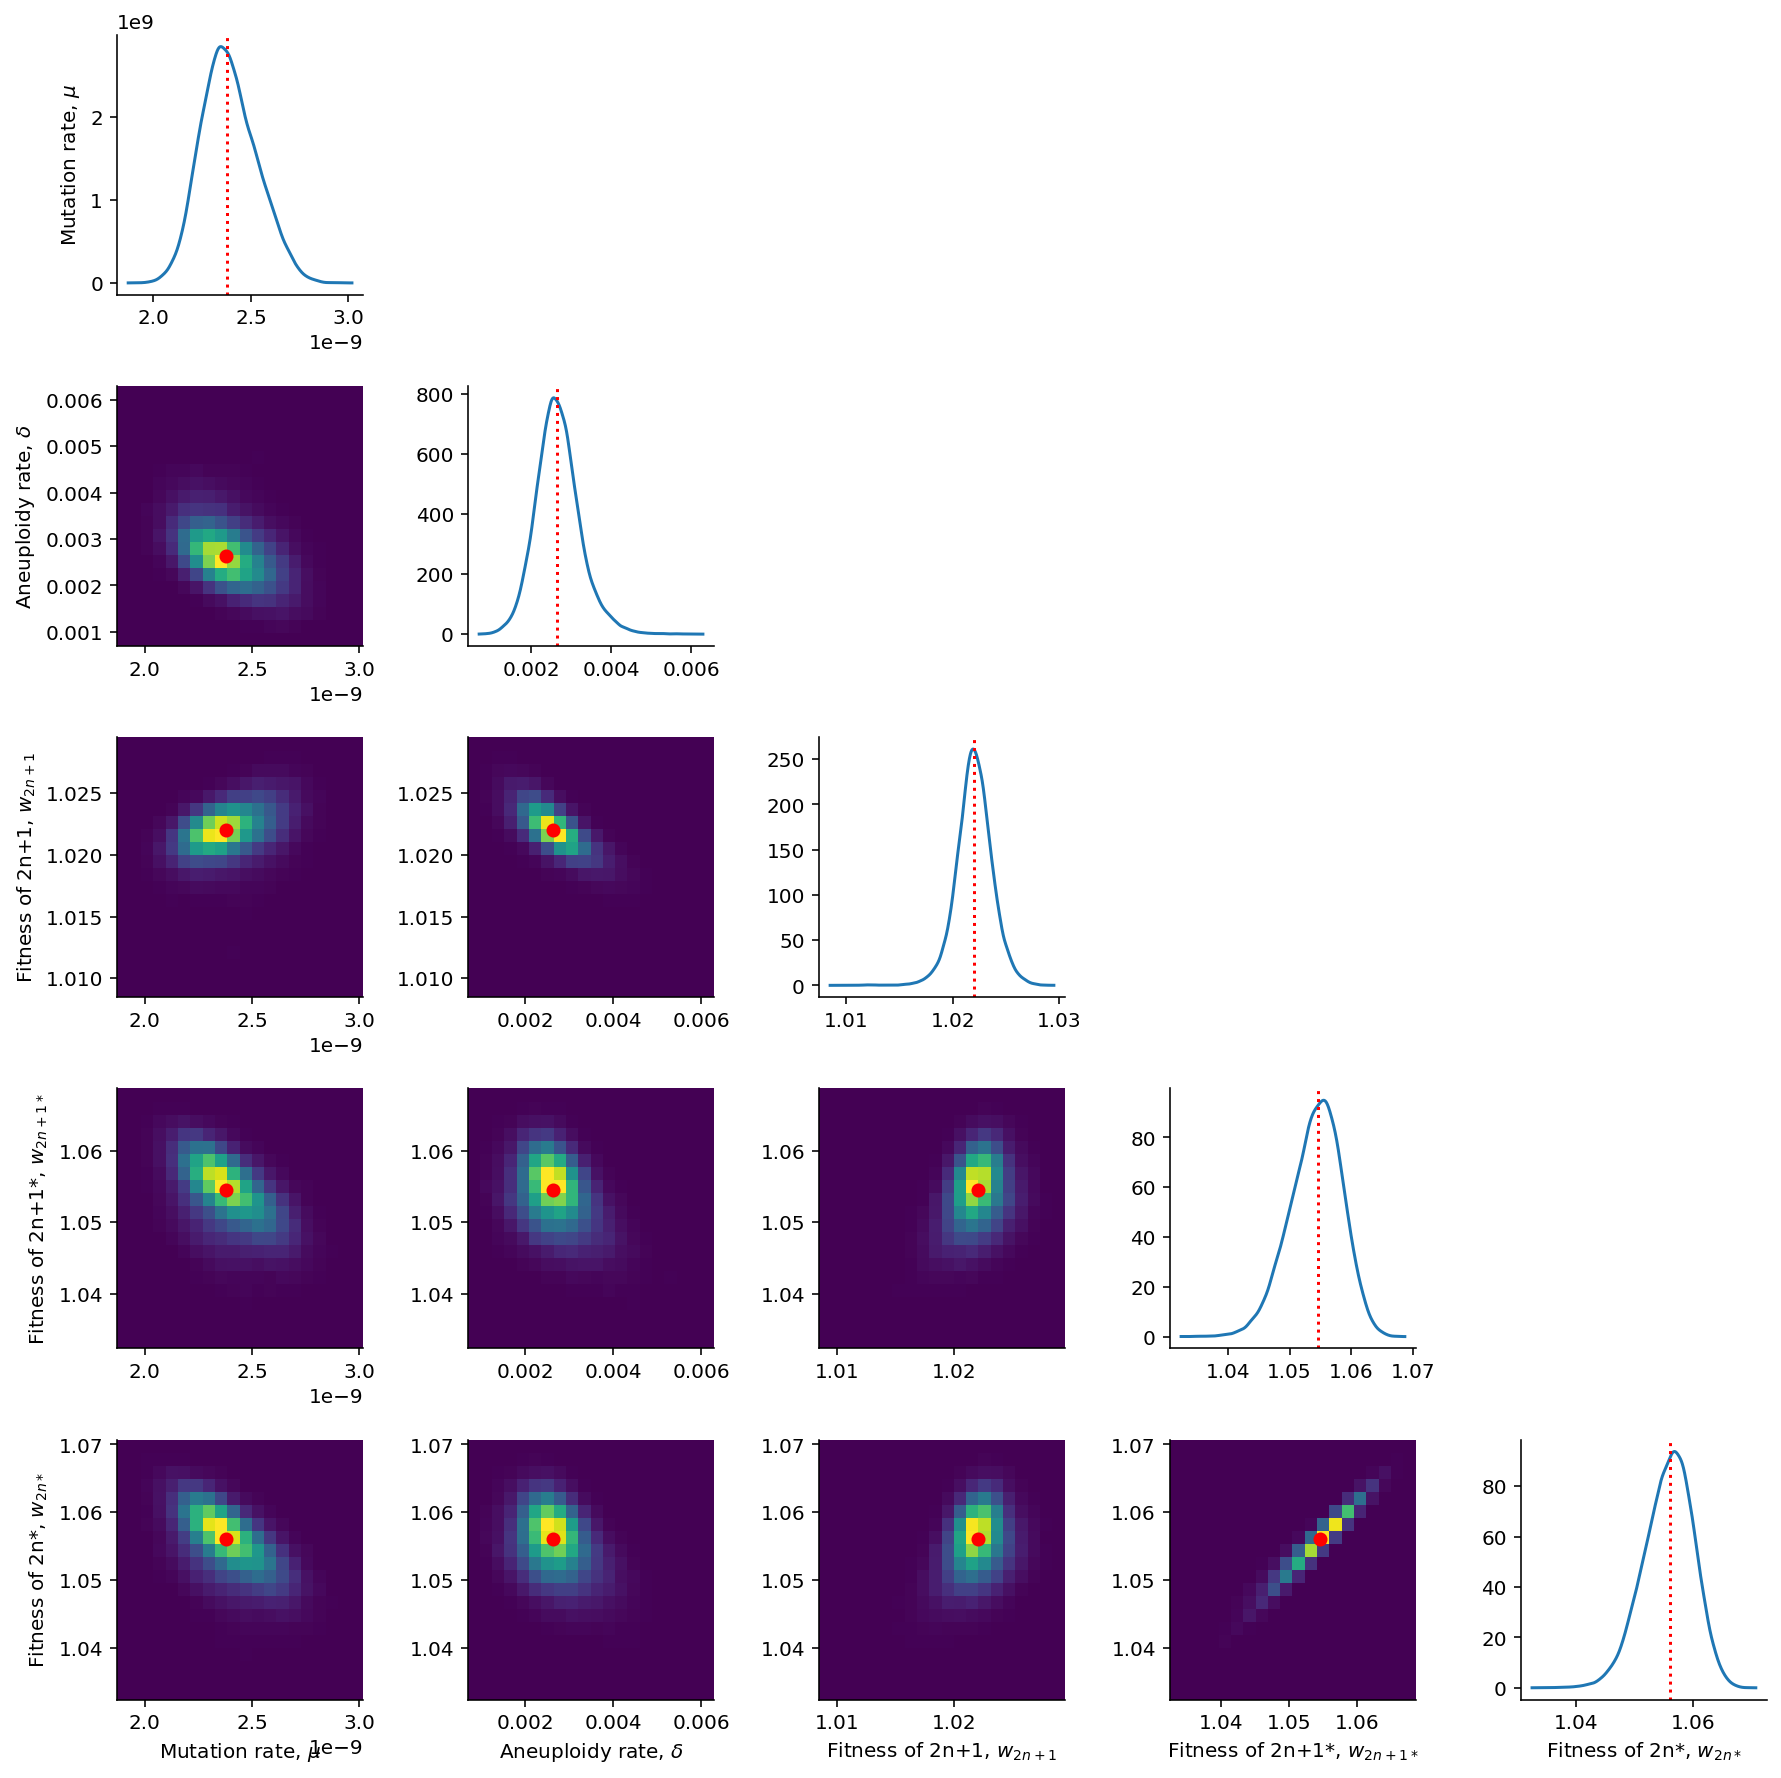

In [26]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=None)
w2 = samples['p3_w1']*samples['p4_w2']
w3 = samples['p3_w1']*samples['p5_w3']
samples['p4_w2'] = w2
samples['p5_w3'] = w3
plot(samples, weights, lims=False, logscale=False)
plt.gcf().savefig(f'{output_path}/posterior-alt.pdf', bbox_inches='tight', dpi=400)

[-1.11598651e+00 -1.60393887e+05 -4.71414572e+06  3.93422436e+07
  3.82931116e+07]


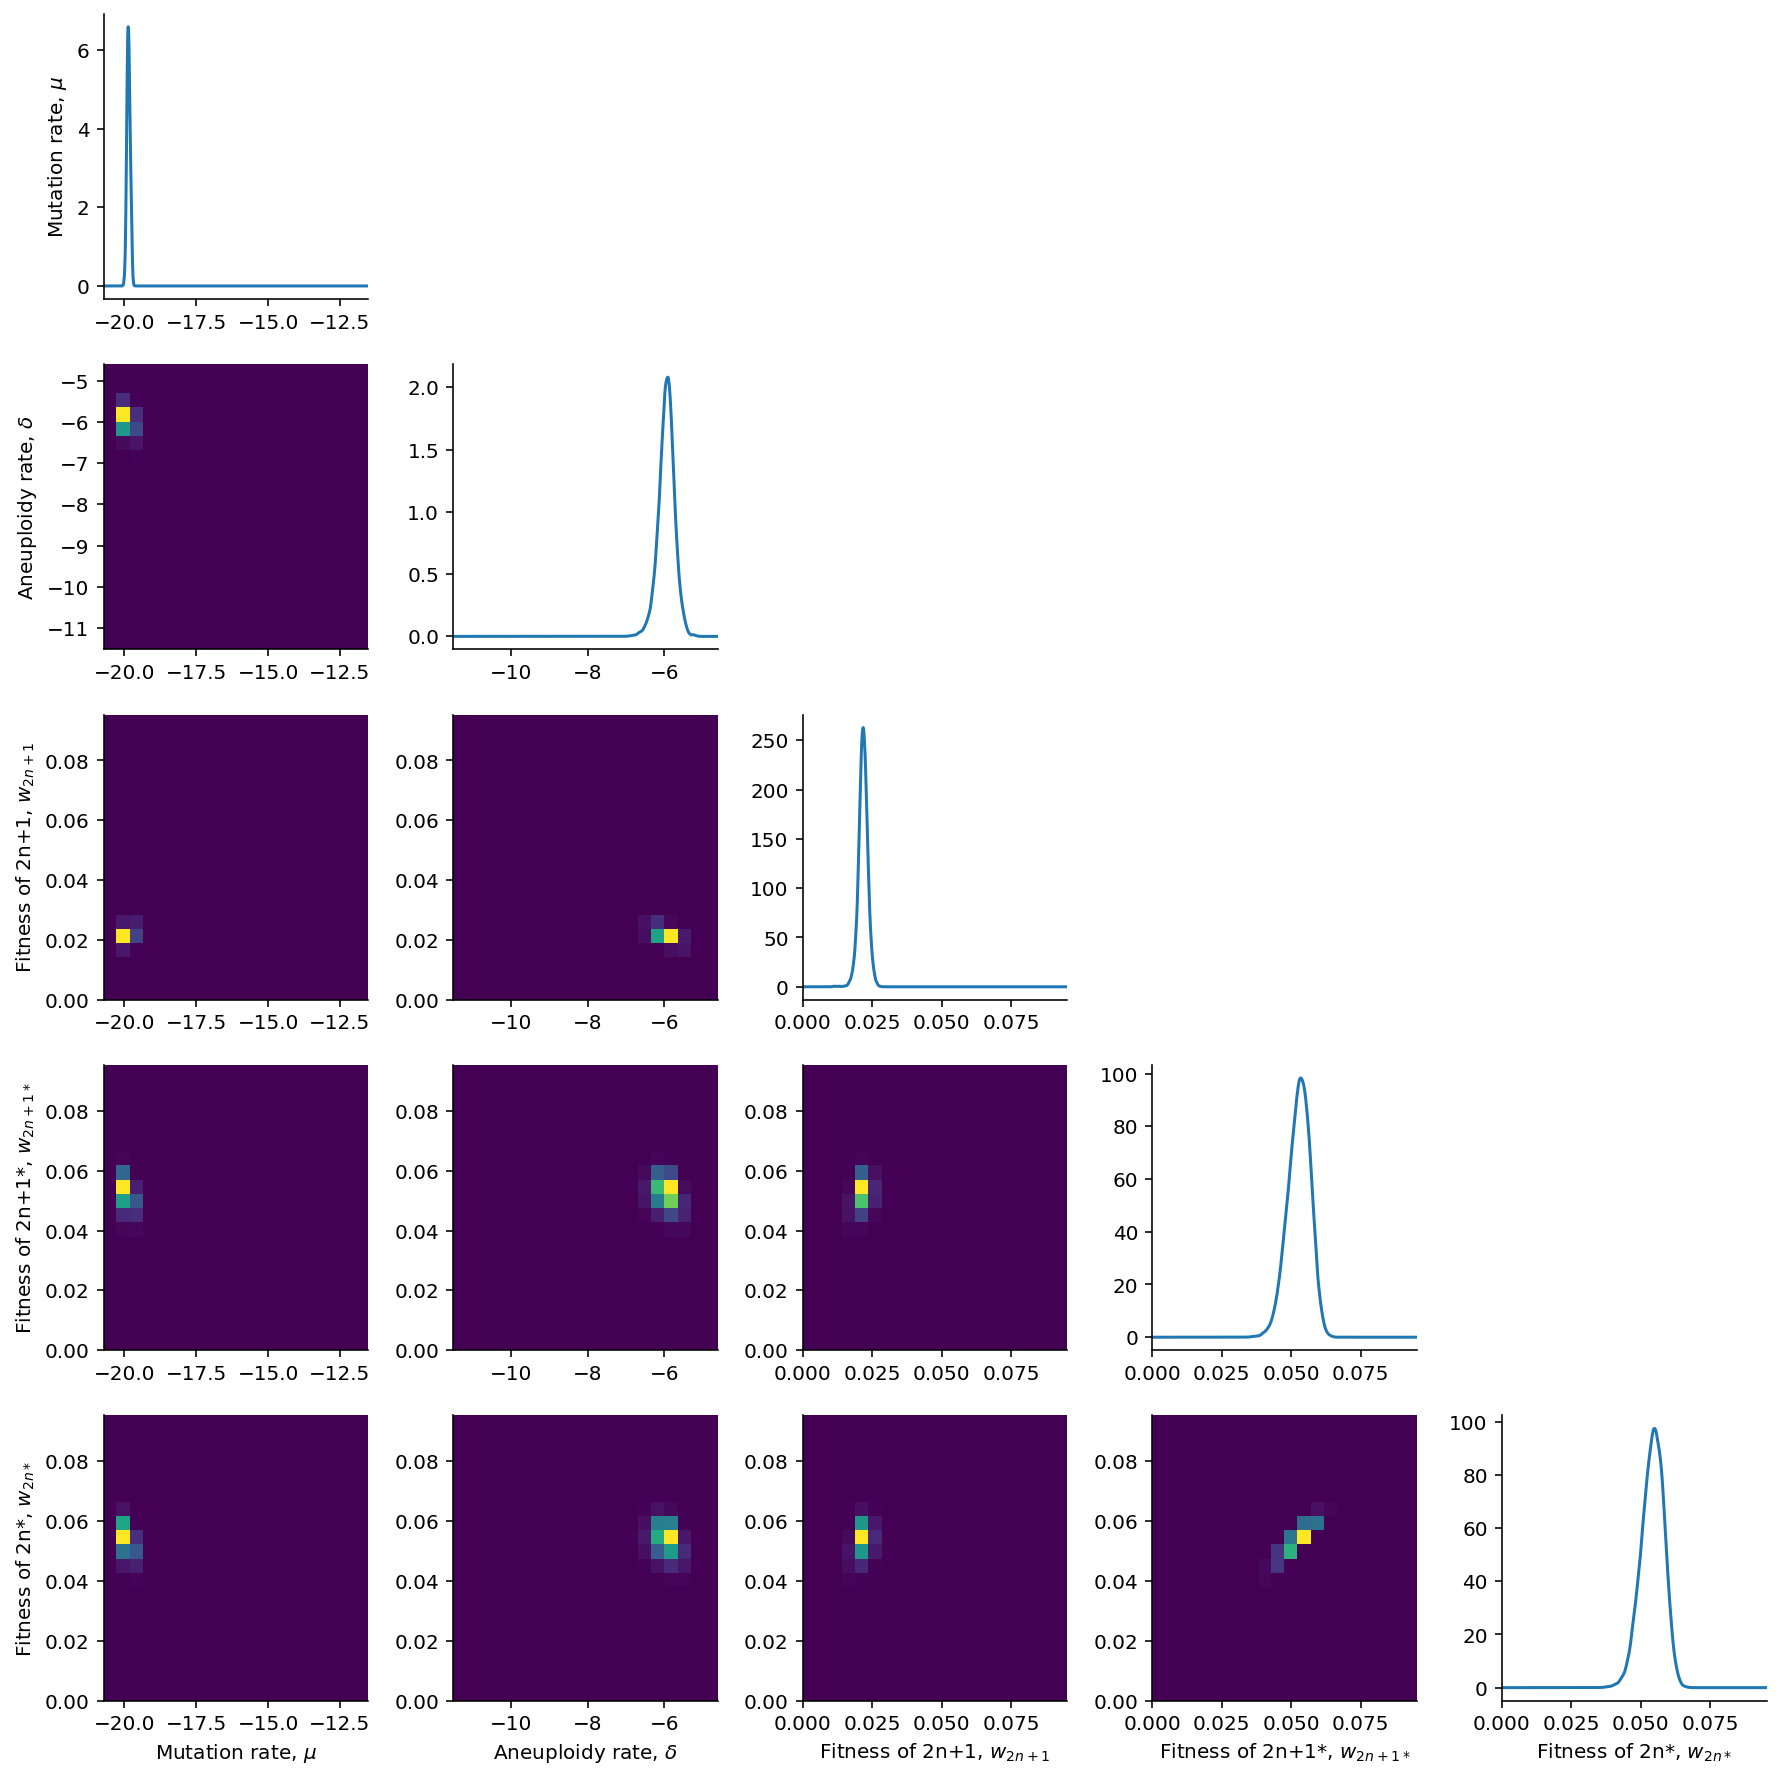

In [25]:
plot(samples, weights, lims=True, logscale=True)

In [28]:
def roundd(v):
    return round(v,3)
        
def findd(n):
    for i in range(0,12):
        m = n*10**i
        if m>=1 and m<=10:
            return i
    raise ValueError(n)
           
# returns (MAP, low_hdi, high_hdi)
def calc_hdi(f, hdi_p=.50):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=None)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples)
    MAP = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    hdi_res = hdi(samples.values, hdi_prob=hdi_p)
    hi = hdi_res.T[1]
    lo = hdi_res.T[0]
    return (MAP, lo, hi)

def print_mode_and_hdi(f, display_cols=['\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'], hdi_p=.50):
    ans = calc_hdi(f,hdi_p)
    orders = [np.array(list(map(findd,ans))) for ans in ans]
    singles = [list(map(roundd,ans*(10**np.array(list(map(findd,ans)))))) for ans in ans]
    for a in list(zip(list(display_cols),*singles, *orders)):
        if a[-1]==0:
            print('${}={}\ [{}-{}]$,'.format(*a))
        else:
            print('${0}={1}\\cdot10^{{-{4}}}\ [{2}\\cdot10^{{-{5}}}-{3}\\cdot10^{{-{6}}}]$,'.format(*a))
    

import warnings
warnings.filterwarnings('ignore')

In [30]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=None)
w2 = samples['p3_w1']*samples['p4_w2']
w3 = samples['p3_w1']*samples['p5_w3']
samples['p4_w2'] = w2
samples['p5_w3'] = w3
print_mode_and_hdi(f, display_cols = ['\mu','\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'])

$\mu=2.379\cdot10^{-9}\ [2.267\cdot10^{-9}-2.458\cdot10^{-9}]$,
$\delta=2.636\cdot10^{-3}\ [2.245\cdot10^{-3}-2.919\cdot10^{-3}]$,
$w_{2n+1}=1.022\ [1.021-1.023]$,
$w_{2n+1^*}=1.032\ [1.03-1.035]$,
$w_{2n^*}=1.033\ [1.031-1.036]$,
